In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn import metrics

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

# df = pd.read_csv('/content/drive/MyDrive/Project/med_inv_dataset.csv') # For Sunith with the shortcut
# df = pd.read_csv('/content/drive/MyDrive/433/Project/med_inv_dataset.csv') # For Akib
df = pd.read_csv('data/med_inv_dataset.csv') # For local

df.columns = df.columns.str.lower()
df.sample(5)

,typeofsales,patient_id,specialisation,dept,dateofbill,quantity,returnquantity,final_cost,final_sales,rtnmrp,formulation,drugname,subcat,subcat1
6803,Sale,12018113968,Specialisation31,Department1,9-29-2022,2,0,620.160,1271.600,0.0,Patent,MEROPENEM 1GM INJ,INJECTIONS,ANTI-INFECTIVES
7444,Sale,12018100390,Specialisation2,Department1,10-08-2022,1,0,51.850,57.568,0.0,Form1,SODIUM CHLORIDE 0.9%,"IV FLUIDS, ELECTROLYTES, TPN",INTRAVENOUS & OTHER STERILE SOLUTIONS
11789,Sale,12018083079,Specialisation4,Department1,09-02-2022,4,0,41.594,162.088,0.0,Form1,WATER FOR INJECTION 10ML SOLUTION,INJECTIONS,INTRAVENOUS & OTHER STERILE SOLUTIONS
6523,Sale,12018096430,Specialisation50,Department1,12-05-2022,2,0,57.472,321.020,0.0,Form1,PARACETAMOL 1GM IV INJ,INJECTIONS,CENTRAL NERVOUS SYSTEM
1941,Sale,12018096947,Specialisation4,Department2,9-20-2022,1,0,49.352,60.800,0.0,Form1,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14218 entries, 0 to 14217
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   typeofsales     14218 non-null  object 
 1   patient_id      14218 non-null  int64  
 2   specialisation  14218 non-null  object 
 3   dept            14218 non-null  object 
 4   dateofbill      14218 non-null  object 
 5   quantity        14218 non-null  int64  
 6   returnquantity  14218 non-null  int64  
 7   final_cost      14218 non-null  float64
 8   final_sales     14218 non-null  float64
 9   rtnmrp          14218 non-null  float64
 10  formulation     13565 non-null  object 
 11  drugname        12550 non-null  object 
 12  subcat          12550 non-null  object 
 13  subcat1         12526 non-null  object 
dtypes: float64(3), int64(3), object(8)
memory usage: 1.5+ MB


In [4]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12037 entries, 0 to 14217
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   typeofsales     12037 non-null  object 
 1   patient_id      12037 non-null  int64  
 2   specialisation  12037 non-null  object 
 3   dept            12037 non-null  object 
 4   dateofbill      12037 non-null  object 
 5   quantity        12037 non-null  int64  
 6   returnquantity  12037 non-null  int64  
 7   final_cost      12037 non-null  float64
 8   final_sales     12037 non-null  float64
 9   rtnmrp          12037 non-null  float64
 10  formulation     12037 non-null  object 
 11  drugname        12037 non-null  object 
 12  subcat          12037 non-null  object 
 13  subcat1         12037 non-null  object 
dtypes: float64(3), int64(3), object(8)
memory usage: 1.4+ MB


In [5]:
# Convert 'dateofbill' to datetime objects
df['dateofbill'] = pd.to_datetime(df['dateofbill'])

# Extract month name
df['month_name'] = df['dateofbill'].dt.strftime('%B')

# Extract month number
df['month_number'] = df['dateofbill'].dt.month
df.head()

,typeofsales,patient_id,specialisation,dept,dateofbill,quantity,returnquantity,final_cost,final_sales,rtnmrp,formulation,drugname,subcat,subcat1,month_name,month_number
0,Sale,12018098765,Specialisation6,Department1,2022-01-06,1,0,55.406,59.260,0.0,Form1,ZINC ACETATE 20MG/5ML SYP,SYRUP & SUSPENSION,VITAMINS & MINERALS,January,1
1,Sale,12018103897,Specialisation7,Department1,2022-07-23,1,0,768.638,950.800,0.0,Form1,CEFTAZIDIME 2GM+AVIBACTAM 500MG,INJECTIONS,ANTI-INFECTIVES,July,7
2,Sale,12018101123,Specialisation2,Department3,2022-06-23,1,0,774.266,4004.214,0.0,Form2,EPTIFIBATIDE 0.75MG/ML,INJECTIONS,CARDIOVASCULAR & HEMATOPOIETIC SYSTEM,June,6
3,Sale,12018079281,Specialisation40,Department1,2022-03-17,2,0,40.798,81.044,0.0,Form1,WATER FOR INJECTION 10ML SOLUTION,INJECTIONS,INTRAVENOUS & OTHER STERILE SOLUTIONS,March,3
4,Sale,12018117928,Specialisation5,Department1,2022-12-21,1,0,40.434,40.504,0.0,Form1,LORAZEPAM 1MG,TABLETS & CAPSULES,CENTRAL NERVOUS SYSTEM,December,12


In [6]:
df_subcat = df.groupby(['subcat',
                        'month_name',
                        'month_number'], as_index=False).agg(
                            {'quantity': 'sum',
                             'returnquantity': 'sum',
                             'final_cost': 'sum',
                             'final_sales': 'sum',
                             'rtnmrp': 'sum'})

In [7]:
df_subcat

,subcat,month_name,month_number,quantity,returnquantity,final_cost,final_sales,rtnmrp
0,DROPS,April,4,7,1,463.880,444.150,50.120
1,DROPS,August,8,4,0,231.614,247.250,0.000
2,DROPS,December,12,1,1,175.586,58.000,142.378
3,DROPS,February,2,2,1,184.290,117.058,79.552
4,DROPS,January,1,1,2,156.832,68.800,98.388
...,...,...,...,...,...,...,...,...
161,VACCINE,March,3,1,0,55.804,58.816,0.000
162,VACCINE,May,5,3,0,170.482,183.258,0.000
163,VACCINE,November,11,3,1,256.290,221.846,58.816
164,VACCINE,October,10,1,1,132.040,58.816,86.826


In [8]:
highest_quantity_subcats = df_subcat.groupby('subcat')['quantity'].sum().nlargest(5)

In [9]:
top_5_cat = highest_quantity_subcats.index.to_list()
highest_quantity_subcats

subcat
INJECTIONS                      12197
IV FLUIDS, ELECTROLYTES, TPN     4716
LIQUIDS & SOLUTIONS              1886
TABLETS & CAPSULES               1607
INHALERS & RESPULES              1469
Name: quantity, dtype: int64

In [10]:
ml_data = df_subcat[df_subcat['subcat'].isin(top_5_cat)].sort_values('month_number')
ml_data.tail(5)

,subcat,month_name,month_number,quantity,returnquantity,final_cost,final_sales,rtnmrp
26,INJECTIONS,December,12,1165,130,137140.242,229072.966,19439.056
147,TABLETS & CAPSULES,December,12,148,8,9744.718,11730.448,493.366
50,LIQUIDS & SOLUTIONS,December,12,346,5,3487.832,17056.366,514.448
38,"IV FLUIDS, ELECTROLYTES, TPN",December,12,401,36,38822.288,66007.448,2092.592
14,INHALERS & RESPULES,December,12,129,48,2198.412,5545.806,2008.672


In [11]:
ml_data['demand'] = ml_data['quantity'] - ml_data['returnquantity']
ml_data['profit'] = ml_data['final_sales'] - ml_data['final_cost']
ml_data.head()

,subcat,month_name,month_number,quantity,returnquantity,final_cost,final_sales,rtnmrp,demand,profit
40,"IV FLUIDS, ELECTROLYTES, TPN",January,1,379,45,21459.376,36753.916,2520.496,334,15294.540
16,INHALERS & RESPULES,January,1,163,7,2011.264,7027.038,289.994,156,5015.774
52,LIQUIDS & SOLUTIONS,January,1,267,6,2565.066,12707.574,612.240,261,10142.508
28,INJECTIONS,January,1,794,73,51451.466,114053.486,12001.932,721,62602.020
149,TABLETS & CAPSULES,January,1,132,7,13122.932,15356.836,700.102,125,2233.904


### Test Dev

In [12]:
ml_df = ml_data[ml_data['subcat'] == 'LIQUIDS & SOLUTIONS'][['month_number', 'demand']]
ml_df['quantity_lastmonth']=ml_df['demand'].shift(+1)
ml_df['quantity_2monthsback']=ml_df['demand'].shift(+2)
ml_df['quantity_3monthsback']=ml_df['demand'].shift(+3)
ml_df = ml_df.dropna()
ml_df.head(12)

,month_number,demand,quantity_lastmonth,quantity_2monthsback,quantity_3monthsback
48,4,82,186.0,63.0,261.0
56,5,119,82.0,186.0,63.0
54,6,33,119.0,82.0,186.0
53,7,134,33.0,119.0,82.0
49,8,137,134.0,33.0,119.0
59,9,12,137.0,134.0,33.0
58,10,185,12.0,137.0,134.0
57,11,304,185.0,12.0,137.0
50,12,341,304.0,185.0,12.0


In [13]:
X = ml_df[['quantity_lastmonth', 'quantity_2monthsback', 'quantity_3monthsback']]
y = ml_df['demand']

In [14]:
seed = 100

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [16]:
model = RandomForestRegressor(random_state=seed)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
eval = [metrics.mean_squared_error(y_test, y_pred),
      metrics.root_mean_squared_error(y_test, y_pred),
      metrics.mean_absolute_percentage_error(y_test, y_pred),]
print(eval)

[2988.82685, 54.67016416657261, 0.29194208494208496]


### Production Ready Code

In [17]:
metric_results = pd.DataFrame(columns=["Model", "MSE", "RMSE", "MAPE", "y_pred"])

In [18]:
def calculate_last_three_months(df, all_filter = False, code = False):
  if not all_filter:
    ml_df = df[df['subcat'] == subcat][['month_number', 'demand']]
  elif code:
    ml_df = df[df['subcat'] == subcat][['month_number', 'subcat_code', 'demand']]
  else:
    ml_df = df[['month_number', 'demand']]
  ml_df['quantity_lastmonth']=ml_df['demand'].shift(+1)
  ml_df['quantity_2monthsback']=ml_df['demand'].shift(+2)
  ml_df['quantity_3monthsback']=ml_df['demand'].shift(+3)

  # option #1
  ml_df = ml_df.dropna() #dropping na is necessary to avoid model failure other option

  # option #2
  # ml_df['quantity_lastmonth'].fillna(ml_df['quantity_lastmonth'].mean())
  # ml_df['quantity_2monthsback'].fillna(ml_df['quantity_2monthsback'].mean())
  # ml_df['quantity_3monthsback'].fillna(ml_df['quantity_3monthsback'].mean())
  if code:
    X = ml_df[['subcat_code', 'quantity_lastmonth', 'quantity_2monthsback', 'quantity_3monthsback']]
  else:
    X = ml_df[['quantity_lastmonth', 'quantity_2monthsback', 'quantity_3monthsback']]
  y = ml_df['demand']
  return X, y

In [19]:
# Train a Random Forest model.
def RandomForest(X, y):
  model = RandomForestRegressor(random_state=seed)
  model.fit(X, y)
  return model

# Calculate classification metrics.
def calculate_metrics(model_type, y_test, y_pred):
  model_results = [
      model_type,
      metrics.mean_squared_error(y_test, y_pred),
      metrics.root_mean_squared_error(y_test, y_pred),
      metrics.mean_absolute_percentage_error(y_test, y_pred),
      y_pred,
  ]
  return model_results

# Trains a model, generates performance metrics, and adds results.
def train_and_evaluate_model(df, X_train, y_train, X_test, y_test, model_type):
  rf = RandomForest(X_train, y_train)
  y_pred = rf.predict(X_test)
  df.loc[len(df)] = calculate_metrics(model_type, y_test, y_pred)

In [20]:
# Train a Random Forest model.
def LinearReg(X, y):
  model = LinearRegression()
  model.fit(X, y)
  return model

def RigdeReg(X, y):
  model = Ridge(random_state=seed)
  model.fit(X, y)
  return model

# Trains a model, generates performance metrics, and adds results.
def train_and_evaluate_linear_model(df, X_train, y_train, X_test, y_test, model_name, model_type="Linear Regression"):
  if model_name == "Linear Regression":
    model = LinearReg(X_train, y_train)
  elif model_name == "Ridge Regression":
    model = RigdeReg(X_train, y_train)
  model = LinearReg(X_train, y_train)
  y_pred = model.predict(X_test)
  df.loc[len(df)] = calculate_metrics(model_name, y_test, y_pred)

In [21]:
y_test_arr = []
for subcat in top_5_cat:
  X, y = calculate_last_three_months(ml_data)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
  y_test_arr.append(y_test)
  train_and_evaluate_model(metric_results, X_train, y_train, X_test, y_test, subcat)

#### For all the cats

In [22]:
df_all = df_subcat.copy()
df_all['demand'] = df_all['quantity'] - df_all['returnquantity']
df_all['profit'] = df_all['final_sales'] - df_all['final_cost']
df_all = df_all.groupby([
                        'month_number'], as_index=False).agg({'demand': 'sum'})
df_all.head()

,month_number,demand
0,1,1688
1,2,1429
2,3,1728
3,4,1767
4,5,1561


In [23]:
X, y = calculate_last_three_months(df_all, all_filter=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
train_and_evaluate_model(metric_results, X_train, y_train, X_test, y_test, "All subcat")

#### Using Linear models

In [24]:
for subcat in top_5_cat:
  X, y = calculate_last_three_months(ml_data)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
  for model_name in ["Linear Regression"]:
    name = subcat + " " + model_name
    train_and_evaluate_linear_model(metric_results, X_train, y_train, X_test, y_test, name,model_type=model_name)

In [25]:
X, y = calculate_last_three_months(df_all, all_filter=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
train_and_evaluate_linear_model(metric_results, X_train, y_train, X_test, y_test, "ALL SUBCAT LINEAR")

#### Model where the subcat level integrity is not lost

In [26]:
target_mapping = {0: 'INHALERS & RESPULES', 1: 'INJECTIONS', 2: 'IV FLUIDS, ELECTROLYTES, TPN', 3: 'LIQUIDS & SOLUTIONS', 4: 'TABLETS & CAPSULES'}

In [27]:
ml_data_test = ml_data.copy()
ml_data_test['subcat_code'] = ml_data_test['subcat'].astype('category').cat.codes
ml_data_test.head()

,subcat,month_name,month_number,quantity,returnquantity,final_cost,final_sales,rtnmrp,demand,profit,subcat_code
40,"IV FLUIDS, ELECTROLYTES, TPN",January,1,379,45,21459.376,36753.916,2520.496,334,15294.540,2
16,INHALERS & RESPULES,January,1,163,7,2011.264,7027.038,289.994,156,5015.774,0
52,LIQUIDS & SOLUTIONS,January,1,267,6,2565.066,12707.574,612.240,261,10142.508,3
28,INJECTIONS,January,1,794,73,51451.466,114053.486,12001.932,721,62602.020,1
149,TABLETS & CAPSULES,January,1,132,7,13122.932,15356.836,700.102,125,2233.904,4


In [ ]:
# X = ml_data_test[['month_number', 'subcat_code']]
# y = ml_data_test['demand']

In [28]:
X_train_final = pd.DataFrame(columns=[
    # 'subcat_code',
    'quantity_lastmonth', 'quantity_2monthsback', 'quantity_3monthsback'])
y_train_final = pd.DataFrame(columns=['demand'])
X_test_final = pd.DataFrame(columns=[
    # 'subcat_code',
    'quantity_lastmonth', 'quantity_2monthsback', 'quantity_3monthsback'])
y_test_final = pd.DataFrame(columns=['demand'])
for subcat in top_5_cat:
  X, y = calculate_last_three_months(ml_data_test)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
  X_train_final = pd.concat([X_train_final, X_train])
  y_train_final = pd.concat([y_train_final, y_train])
  X_test_final = pd.concat([X_test_final, X_test])
  y_test_final = pd.concat([y_test_final, y_test])

/var/folders/dc/n7cp43k94blc5lmsv8p725pc0000gn/T/ipykernel_25332/1260890033.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  X_train_final = pd.concat([X_train_final, X_train])
/var/folders/dc/n7cp43k94blc5lmsv8p725pc0000gn/T/ipykernel_25332/1260890033.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  X_test_final = pd.concat([X_test_final, X_test])


In [29]:
X_test_final

,quantity_lastmonth,quantity_2monthsback,quantity_3monthsback
32,929.0,891.0,808.0
34,1068.0,1010.0,909.0
44,412.0,372.0,299.0
46,313.0,398.0,405.0
56,82.0,186.0,63.0
58,12.0,137.0,134.0
153,163.0,114.0,90.0
155,108.0,141.0,108.0
20,74.0,79.0,79.0
22,137.0,136.0,126.0


In [30]:
train_and_evaluate_model(metric_results, X_train_final, y_train_final, X_test_final, y_test_final, "no subcat code seed 100")

/Users/sunith/opt/anaconda3/envs/dss/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


#### Final table

In [31]:
# metric_results = metric_results.drop(columns=["y_pred"])
output_to_show = metric_results[["Model", "MSE", "RMSE", "MAPE"]]
output_to_show

,Model,MSE,RMSE,MAPE
0,INJECTIONS,47033.636000,216.872396,0.264858
1,"IV FLUIDS, ELECTROLYTES, TPN",4196.245850,64.778437,0.194658
2,LIQUIDS & SOLUTIONS,2988.826850,54.670164,0.291942
3,TABLETS & CAPSULES,506.407450,22.503499,0.152210
4,INHALERS & RESPULES,1513.166850,38.899445,0.390353
5,All subcat,63143.865450,251.284431,0.151227
6,INJECTIONS Linear Regression,63031.258312,251.060268,0.315338
7,"IV FLUIDS, ELECTROLYTES, TPN Linear Regression",337.121735,18.360875,0.055039
8,LIQUIDS & SOLUTIONS Linear Regression,34604.692979,186.023367,1.072735
9,TABLETS & CAPSULES Linear Regression,1385.706817,37.225083,0.271238


Subcat coding as a feature column has no impact on the prediction.

### Visualizations

In [ ]:
# prompt: in the loop keep adding all the y_test and y_pred  and finally show them as one table

# Create a list to store the y_test and y_pred values for each subcat
all_y_test = []
all_y_pred = []
all_subcats = []

for subcat in top_5_cat:
  X, y = calculate_last_three_months(ml_data)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

  rf_model = RandomForest(X_train, y_train)
  y_pred = rf_model.predict(X_test)

  all_y_test.extend(y_test)
  all_y_pred.extend(y_pred)
  all_subcats.extend([subcat] * len(y_test))

In [ ]:
# Create a DataFrame to display the combined y_test and y_pred values
combined_results = pd.DataFrame({'Subcategory': all_subcats, 'y_test': all_y_test, 'y_pred': all_y_pred})
combined_results

,Subcategory,y_test,y_pred
0,INJECTIONS,721,998.64
1,INJECTIONS,901,1031.32
2,"IV FLUIDS, ELECTROLYTES, TPN",406,374.46
3,"IV FLUIDS, ELECTROLYTES, TPN",276,362.01
4,LIQUIDS & SOLUTIONS,119,97.24
5,LIQUIDS & SOLUTIONS,185,110.81
6,TABLETS & CAPSULES,130,130.55
7,TABLETS & CAPSULES,106,137.82
8,INHALERS & RESPULES,92,93.56
9,INHALERS & RESPULES,72,126.99


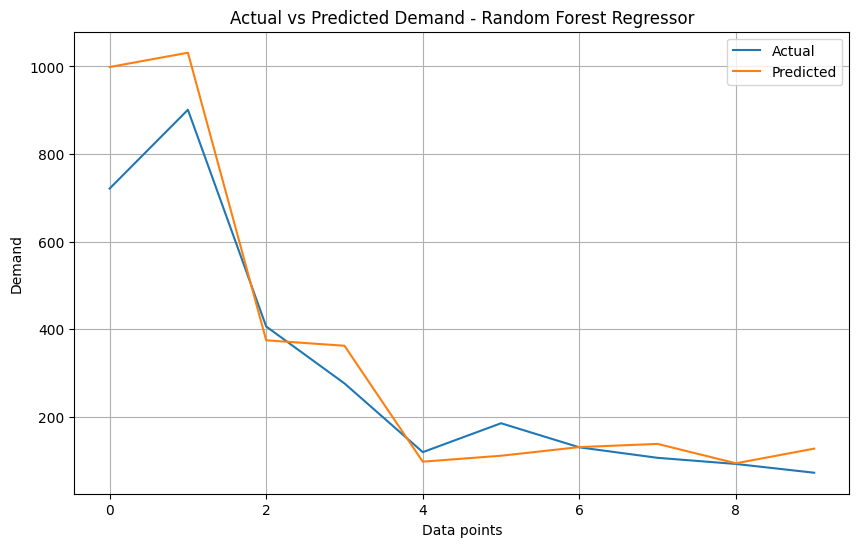

In [ ]:
# prompt: generate a line plot using y_test and y_pred as two lines, actual and predicted with index as the x

import matplotlib.pyplot as plt

# Assuming 'combined_results' DataFrame is available from the previous code

plt.figure(figsize=(10, 6))
plt.plot(combined_results.index, combined_results['y_test'], label='Actual')
plt.plot(combined_results.index, combined_results['y_pred'], label='Predicted')
plt.xlabel('Data points')
plt.ylabel('Demand')
plt.title('Actual vs Predicted Demand - Random Forest Regressor')
plt.legend()
plt.grid(True)
plt.show()


We can visualize the demand over time for each of the subcats to see how they actually faired over time.

In [ ]:
filter_category = 'INJECTIONS'

In [ ]:
filtered_df = df[df['subcat'] == filter_category].sort_values('dateofbill')
filtered_df['demand'] = filtered_df['quantity'] - filtered_df['returnquantity']
filtered_df.head()

,typeofsales,patient_id,specialisation,dept,dateofbill,quantity,returnquantity,final_cost,final_sales,rtnmrp,formulation,drugname,subcat,subcat1,month_name,month_number,demand
9916,Sale,12018080633,Specialisation14,Department1,2022-01-01,1,0,77.800,125.586,0.0,Form2,ENOXAPARIN 40MG,INJECTIONS,CARDIOVASCULAR & HEMATOPOIETIC SYSTEM,January,1,1
154,Sale,12018081316,Specialisation3,Department1,2022-01-01,2,0,49.278,104.204,0.0,Form1,CEFTRIAXONE 1GM,INJECTIONS,ANTI-INFECTIVES,January,1,2
14055,Sale,12018064578,Specialisation10,Department2,2022-01-01,3,0,120.640,307.800,0.0,Form1,PROPOFOL 1% 20ML INJ,INJECTIONS,ANAESTHETICS,January,1,3
11052,Sale,12018076250,Specialisation5,Department1,2022-01-01,1,0,42.060,42.600,0.0,Form1,GLYCOPYRROLATE,INJECTIONS,MUSCULO-SKELETAL SYSTEM,January,1,1
9776,Sale,12018081582,Specialisation3,Department1,2022-01-01,3,0,66.208,448.680,0.0,Form1,PARACETAMOL 1GM IV INJ,INJECTIONS,CENTRAL NERVOUS SYSTEM,January,1,3


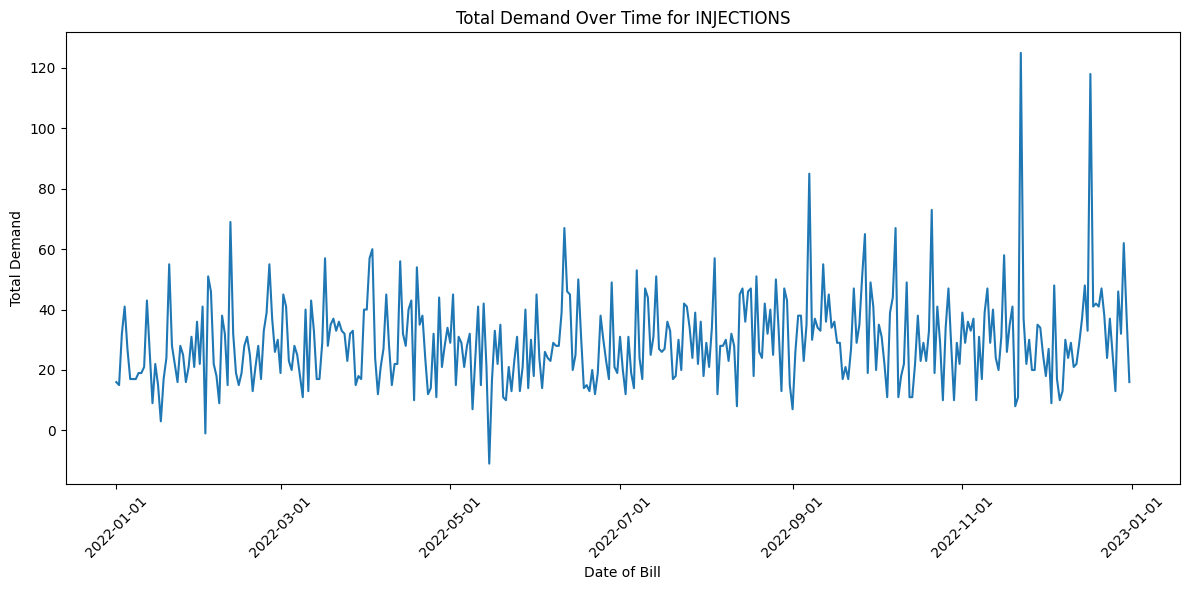

In [ ]:
# Aggregate filtered_df by dateofbill, sum demand, and visualize
demand_by_date = filtered_df.groupby('dateofbill')['demand'].sum()

plt.figure(figsize=(12, 6))
plt.plot(demand_by_date.index, demand_by_date.values)
plt.xlabel('Date of Bill')
plt.ylabel('Total Demand')
plt.title(f'Total Demand Over Time for {filter_category}')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.tight_layout()
plt.show()

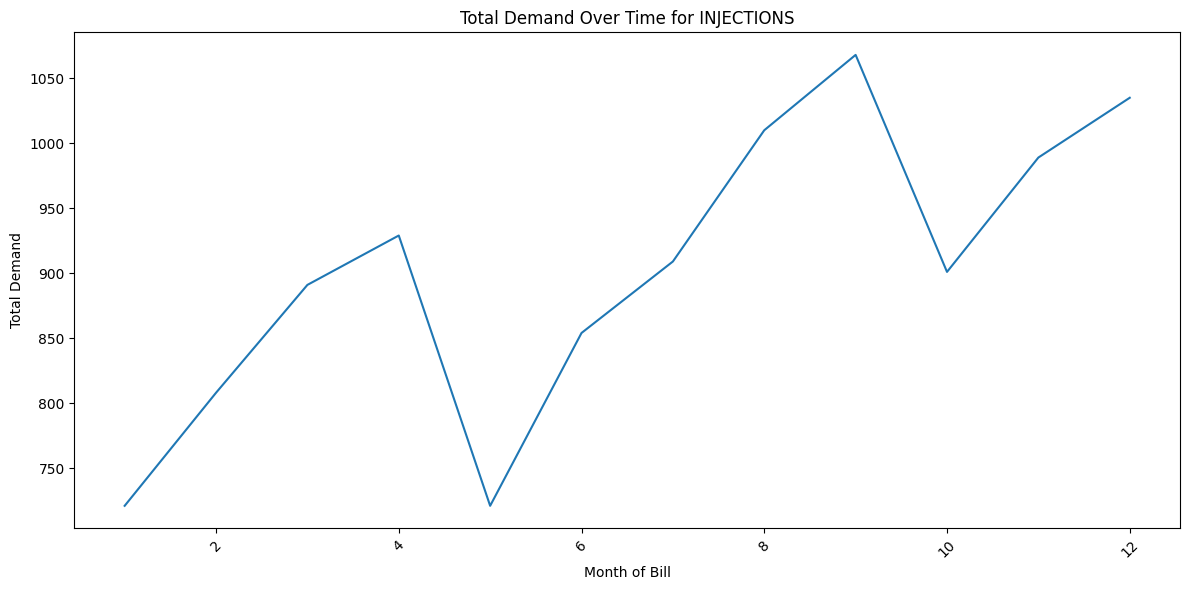

In [ ]:
demand_by_month = filtered_df.groupby('month_number')['demand'].sum()

plt.figure(figsize=(12, 6))
plt.plot(demand_by_month.index, demand_by_month.values)
plt.xlabel('Month of Bill')
plt.ylabel('Total Demand')
plt.title(f'Total Demand Over Time for {filter_category}')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()